In [63]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

#warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


In [64]:
data = pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TRAIN.txt', sep = ',', low_memory=False)
data=data.drop(['ID_Customer'], axis=1)
testdata=pd.read_csv('Dataset_Salesforce_Predictive_Modelling_TEST.txt', sep = ',', low_memory=False)
test_ids = testdata['ID_Customer'] #save id column from test
testdata=testdata.drop(['ID_Customer'], axis=1)
list_columns_test=list(testdata.columns.values)

In [66]:
#Ver el nombre de las columnas para saber cuales sumar (buscar la mayor correlación)
list_columns=list(data.columns.values)
Names_Imp_cons=list_columns[0:17]
#Importe de consumos habituales del cliente en base a sus operaciones con tarjetas y domiciliaciones más comunes
data['Imp_cons_total'] = data[Names_Imp_cons].sum(axis=1)
#Importe de los saldos de los distintos productos financieros.
Names_Imp_Sal=list_columns[17:38]
data['Imp_sal_total'] = data[Names_Imp_Sal].sum(axis=1)
#Tenencia de los distintos productos financieros. Son indices entre 0 y 2 por lo que el sumatorio también valdra
#ya que cuanta más puntuación saque el sumatorio más productos compra
Names_Ind_Prod=list_columns[38:62]
data['Ind_prod_total'] = data[Names_Ind_Prod].sum(axis=1)
#Número de operaciones a través de los distintos productos financieros.
Names_Num_Oper=list_columns[62:82]
data['Num_Oper_total'] = data[Names_Num_Oper].sum(axis=1)
#datasetfinal
df = data[['Imp_cons_total', 'Imp_sal_total', 'Ind_prod_total','Num_Oper_total','Socio_Demo_01','Socio_Demo_02','Socio_Demo_03','Socio_Demo_04','Socio_Demo_05','Poder_Adquisitivo']].copy()

#hacemos lo mismo con lo de test (la lista que contiene nombres nos sirve la misma)

testdata['Imp_cons_total'] = testdata[Names_Imp_cons].sum(axis=1)
testdata['Imp_sal_total'] = testdata[Names_Imp_Sal].sum(axis=1)
testdata['Ind_prod_total'] = testdata[Names_Ind_Prod].sum(axis=1)
testdata['Num_Oper_total'] = testdata[Names_Num_Oper].sum(axis=1)

df_test = testdata[['Imp_cons_total', 'Imp_sal_total', 'Ind_prod_total','Num_Oper_total','Socio_Demo_01','Socio_Demo_02','Socio_Demo_03','Socio_Demo_04','Socio_Demo_05']].copy()

In [54]:
#VARIABLES DE CADA TIPO

df.dtypes.value_counts() 


int64      5
float64    4
object     1
dtype: int64

In [55]:
#VARIABLES DE CADA TIPO

numeric_cols=df.select_dtypes(include=[np.number]).columns#select only numerical
nominal_cols=df.select_dtypes(exclude=[np.number]).columns#select only non numerical
print(numeric_cols.shape[0],'numeric columns: ',numeric_cols)
print(nominal_cols.shape[0],'nominal columns: ',nominal_cols)

9 numeric columns:  Index(['Imp_cons_total', 'Imp_sal_total', 'Ind_prod_total', 'Num_Oper_total',
       'Socio_Demo_02', 'Socio_Demo_03', 'Socio_Demo_04', 'Socio_Demo_05',
       'Poder_Adquisitivo'],
      dtype='object')
1 nominal columns:  Index(['Socio_Demo_01'], dtype='object')


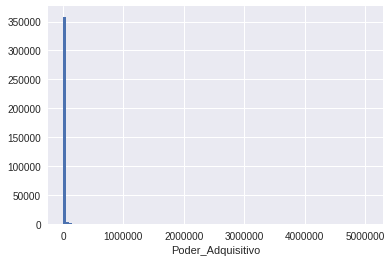

In [56]:
#BARPLOT DEL PODER ADQUISITIVO. 95% DE POBRES CON 5% DE RICOS. ASI DE BIEN VAN LAS COSAS
fig, ax = plt.subplots()
ax.hist(df['Poder_Adquisitivo'],100)
ax.set_xlabel('Poder_Adquisitivo')
plt.show()

In [57]:
description=df['Poder_Adquisitivo'].describe()
print(description)
iqr=description['75%']-description['25%']
limits=[description['25%']-1.5*iqr,description['75%']+1.5*iqr]
print('limits (lower,upper)',limits)
#NO HAY NADIE POR DEBAJO DEL LIMITE INFERIOR
print('Valores anomalos',df[df['Poder_Adquisitivo']>limits[1]].shape[0])
#SON DEMASIADOS. VOY A QUITAR SOLO A LOS MUY RICOS QUE SOLO SON 33 
df=df[df['Poder_Adquisitivo']<=1000000]


count    3.638340e+05
mean     1.642141e+04
std      2.436773e+04
min      3.600960e+03
25%      9.300933e+03
50%      1.292517e+04
75%      1.894854e+04
max      5.040000e+06
Name: Poder_Adquisitivo, dtype: float64
limits (lower,upper) [-5170.4740936249964, 33419.943489375]
Valores anomalos 20840


In [67]:
#CONCATENAMOS AMBOS CONJUNTOS PARA APLICAR TRANSFORMACIONES

data=pd.concat([df,df_test],axis=0,ignore_index=True) #concatenate training and test set for future transformations
print(data['Poder_Adquisitivo'].head())#Don't worry about the SalePrice variable that is not in test. 
print(data['Poder_Adquisitivo'].tail()) #It's filled with NAs

0    19709.915000
1    37497.492167
2     4802.970000
3     8295.770000
4    24149.321667
Name: Poder_Adquisitivo, dtype: float64
520144   NaN
520145   NaN
520146   NaN
520147   NaN
520148   NaN
Name: Poder_Adquisitivo, dtype: float64


In [68]:
#VALORES NUMERICOS FALTANTES

missing_values=data.isnull().sum() #obtain the number of missing values by column
numeric_missing=missing_values[numeric_cols] #separate the numeric variables
numeric_missing['Poder_Adquisitivo']=0 #We don't want to detect SalePrice's NAs because they are not real, they just belong to test set
numeric_missing[numeric_missing>0]

#NO FALTAN VALORES NUMERICOS

Series([], dtype: int64)

In [69]:
#VALORES NOMINALES FALTANTES

nominal_missing=missing_values[nominal_cols] 
nominal_missing=nominal_missing[nominal_missing>0]
nominal_missing_df= pd.DataFrame()
nominal_missing_df[['absolute','relative']]= pd.concat([nominal_missing,nominal_missing/data.shape[0]],axis=1)
nominal_missing_df

#HABRA QUE ESTUDIAR BIEN LA COLUMNA Socio_Demo_01, DE MOMENTO ME LA CARGO PARA QUE ESTO FUNCIONE

data=data.drop(['Socio_Demo_01'],axis=1) #remove columns
nominal_cols=nominal_cols[nominal_cols!='Socio_Demo_01']

In [70]:
stdSc = StandardScaler()

numeric_cols=numeric_cols[numeric_cols!='Poder_Adquisitivo'] #We don't want to scale SalePrice

data.loc[:, numeric_cols] = stdSc.fit_transform(data.loc[:, numeric_cols])

In [72]:
#SEPARAMOS DE NUEVO LOS CONJUNTOS

traindata=data.iloc[:df.shape[0],:] 
testdata=data.iloc[df.shape[0]:,:]
testdata=testdata.drop('Poder_Adquisitivo',axis=1) #We drop the unknown variable in the test. It was just filled with NAs

X_traindata=traindata.drop('Poder_Adquisitivo',axis=1)
y_traindata=traindata['Poder_Adquisitivo']


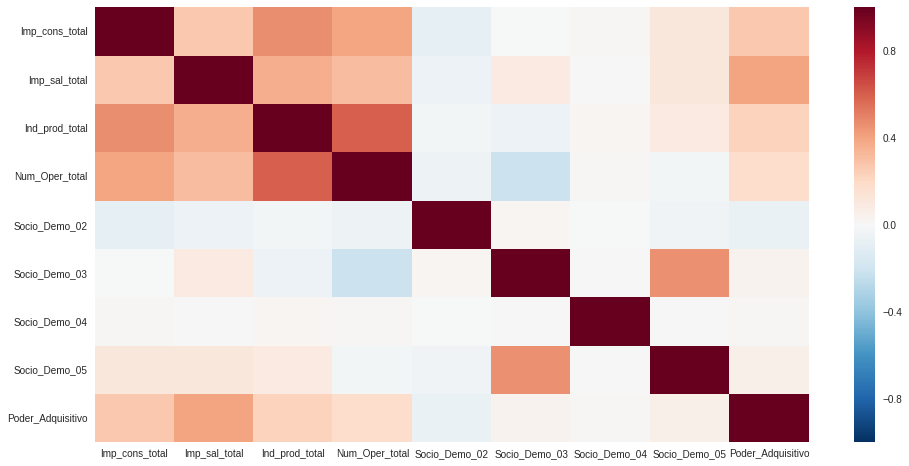

In [73]:
numeric_cols=np.hstack([numeric_cols,'Poder_Adquisitivo'])

#MATRIZ DE CORRELACIONES CON TODAS LAS VARIABLES
correlation=traindata[numeric_cols].corr() #obtain the correlation matrix
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation,ax=ax)
plt.show() #draw the correlation matrix

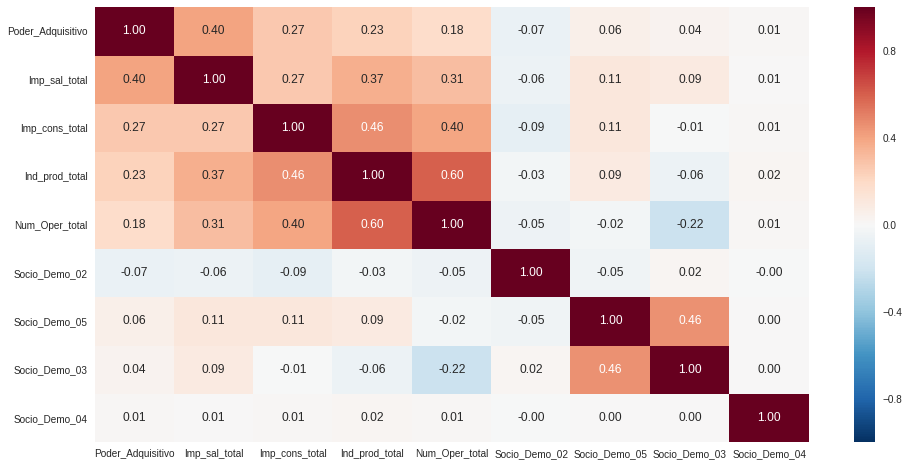

In [75]:
#VAMOS A MOSTRAR LAS SOLO 20 MEJORES VARIABLES
aux=abs(correlation['Poder_Adquisitivo']).sort_values(ascending=False) #sort variables by their correlation with SalePrice
selected_feats=aux[0:20].index
sns.set()
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(correlation.loc[selected_feats,selected_feats], annot=True,fmt='.2f',ax=ax)
plt.show()

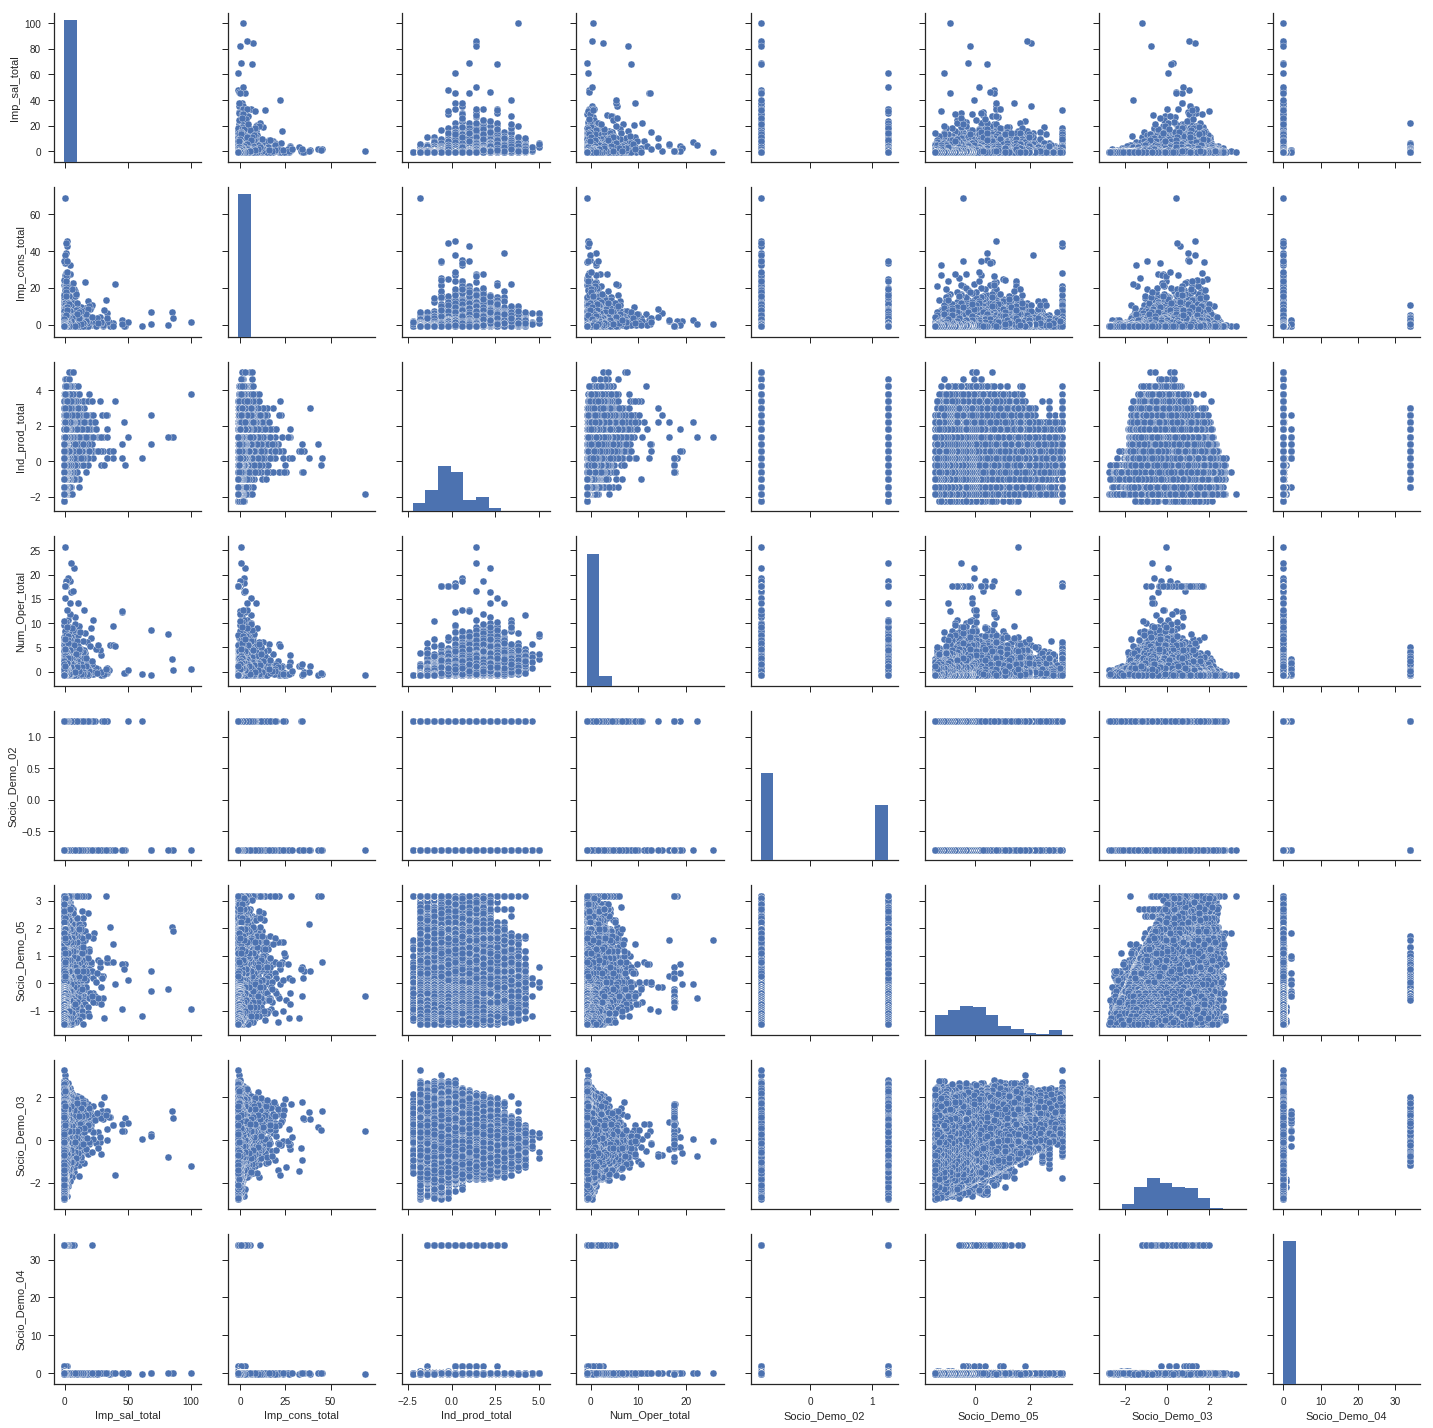

In [76]:
#MOSTRAR SCATTER MATRIX DE LAS 10 MEJORES VARIABLES SIN CONTAR LA OBJETIVO
selected_feats=aux[1:11].index
sns.set(style="ticks")
sns.pairplot(traindata[selected_feats])
plt.show()

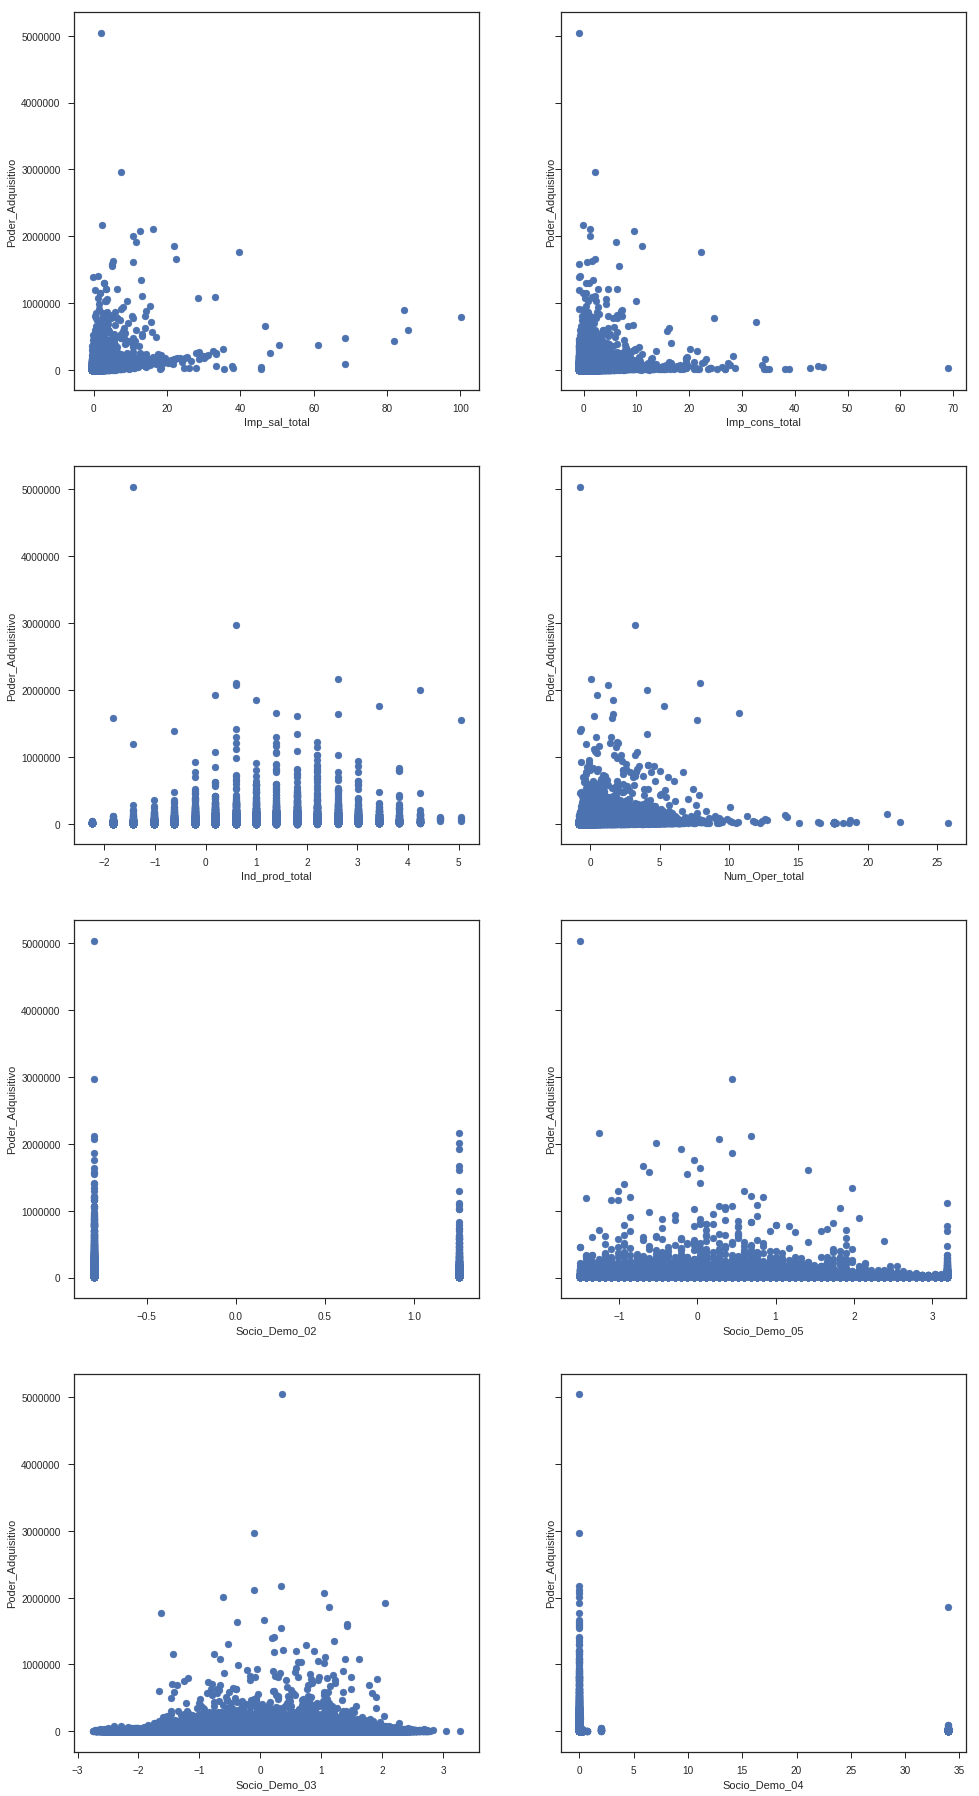

In [87]:
#SCATTERS DE LAS VARIABLES MAS IMPORTANTES CON LA OBJETIVO

selected_feats=aux[1:21].index

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(16,32),sharey=True)
axes=axes.flatten()

for i in range(len(axes)):
    axes[i].scatter(traindata[selected_feats[i]],traindata['Poder_Adquisitivo'])
    axes[i].set_xlabel(selected_feats[i])
    axes[i].set_ylabel('Poder_Adquisitivo')
plt.show()

In [88]:

#ESTA FUNCIÓN CALCULA EL ERROR ABSOLUTO MEDIO CON CROSS VALIDATION
def rmse_cv(model,X, y):
    return -cross_val_score(model, X, y, scoring = scorer, cv = 10)
#mean_absolute_error
scorer = make_scorer(mean_absolute_error, greater_is_better = False)

#HE USADO ESTA COMO BASE
#HABRA QUE PROBAR MAS REGRESORES CON SUS PARAMETROS
regressor=RidgeCV([0.05, 0.1, 0.3, 0.6, 1, 1.5, 3, 5, 10, 15, 30, 50, 80])
print('mean absolute error (cross validation):',rmse_cv(regressor,X_traindata,y_traindata).mean()) #show the estimate of the test error

mean absolute error (cross validation): 5904.61040259
